In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import skimage.color as color

from torch.utils.data import DataLoader
from torchvision import datasets as dsets, transforms as tf
from torchvision.utils import make_grid
from collections import OrderedDict

In [8]:
data_root = '/Datasets/CIFAR10/.'
data_root_places = '/Datasets/Places365/train/.'
workers = 4
lr = 1e-4
nc=3
nz=3
nf = 64
beta1 = 9e-1
batch_limit = 1000
weight_decay = 1e-3

In [3]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if is_cuda else 'cpu')
device

device(type='cuda', index=0)

In [4]:
class RGB2LAB(object):

    def __call__(self, image):
        """
        :param image: PIL/NumPy image to be converted.
        :return: the LAB color channel image.
        """
        return color.rgb2lab(np.array(image))

In [5]:
def lab2rgb(image, dim=None):
    """
    :param image is a single Lab image the shape of (X, y, 3)
    :param dim to define the color-channel dimension.
    """
    image = np.transpose(image, axes=(1, 2, 0))

    if dim is not None:
        z = np.zeros_like(image)
        if dim != 0:
            z[:, :, 0] = 80  # Increase the brightness to see other color channels(a & b).

        z[:, :, dim] = image[:, :, dim]
        return color.lab2rgb(z)
    else:
        return color.lab2rgb(image)

In [6]:
transforms = {
    'mnist': tf.Compose([
        tf.ToTensor()
    ]),
    'cifar': tf.Compose([
        tf.ToTensor()
    ]),
    'places365': tf.Compose([
        tf.ToTensor()
    ])
}

In [7]:
train_dataset = dsets.CIFAR10(root=data_root, train=True, download=True, transform=transforms['cifar'])
test_dataset = dsets.CIFAR10(root=data_root, train=False, download=True, transform=transforms['cifar'])

print(train_dataset, test_dataset, sep='\n\n')

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /Datasets/CIFAR10/.
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: /Datasets/CIFAR10/.
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [8]:
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=False, num_workers=workers, pin_memory=is_cuda)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=workers, pin_memory=is_cuda)

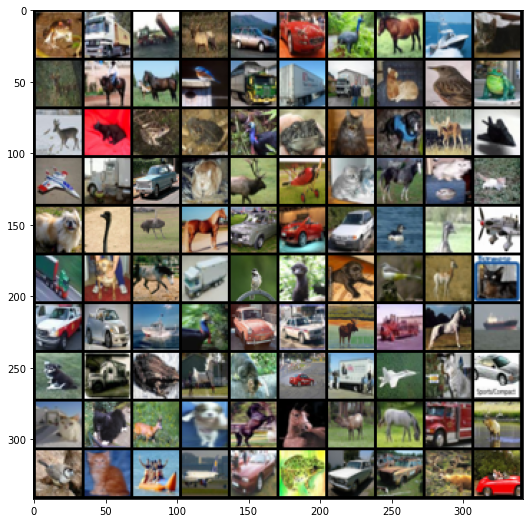

In [9]:
im = next(iter(train_loader))

grid = make_grid(im[0], nrow=10, normalize=True)

plt.figure(figsize=(10 ,9))
plt.imshow(np.transpose(grid, axes=(1, 2, 0)))

In [8]:
class AutoEncoderMNIST(nn.Module):

    def __init__(self, in_channels=nc, out_channels=nz):
        super(AutoEncoderMNIST, self).__init__()
        pad = (0, 1, 0, 1)

        self.encode = nn.Sequential(OrderedDict([
            ('conv1', nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=nf, kernel_size=4, stride=2),
                nn.ReplicationPad2d(padding=pad),
                nn.ReLU()
            )),
            ('conv2', nn.Sequential(
                nn.Conv2d(in_channels=nf, out_channels=nf * 2, kernel_size=4, stride=2),
                nn.ReplicationPad2d(padding=pad),
                nn.BatchNorm2d(nf * 2),
                nn.ReLU()
            )),
            ('conv3', nn.Sequential(
                nn.Conv2d(in_channels=nf * 2, out_channels=nf * 4, kernel_size=4, stride=2),
                nn.ReplicationPad2d(padding=(1, 1, 1, 1)),
                nn.BatchNorm2d(nf * 4),
                nn.ReLU()
            )),
            ('conv4', nn.Sequential(
                nn.Conv2d(in_channels=nf * 4, out_channels=nf * 8, kernel_size=4, stride=1),
                nn.BatchNorm2d(nf * 8),
                nn.ReLU()
            ))
        ]))

        self.decode = nn.Sequential(OrderedDict([
            ('conv1', nn.Sequential(
                nn.ConvTranspose2d(in_channels=nf * 8, out_channels=nf * 4, kernel_size=4, stride=1),
                nn.BatchNorm2d(nf * 4),
                nn.ReLU()
            )),
            ('conv2', nn.Sequential(
                nn.ConvTranspose2d(in_channels=nf * 4, out_channels=nf * 2, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(nf * 2),
                nn.ReLU()
            )),
            ('conv3', nn.Sequential(
                nn.ConvTranspose2d(in_channels=nf * 2, out_channels=nf, kernel_size=4, stride=2, padding=2),
                nn.BatchNorm2d(nf),
                nn.ReLU()
            )),
            ('conv4', nn.Sequential(
                nn.ConvTranspose2d(in_channels=nf, out_channels=out_channels, kernel_size=4, stride=2, padding=1),
                nn.ReLU()
            ))
        ]))

    def forward(self, x):
        x = self.encode(x)
        return self.decode(x)


acNet = AutoEncoderMNIST().to(device)
acNet

AutoEncoder(
  (encode): Sequential(
    (conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2))
      (1): ReplicationPad2d((0, 1, 0, 1))
      (2): ReLU()
    )
    (conv2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
      (1): ReplicationPad2d((0, 1, 0, 1))
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
    )
    (conv3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
      (1): ReplicationPad2d((1, 1, 1, 1))
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
    )
    (conv4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (decode): Sequential(
    (conv1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=

In [19]:
class AutoEncoderCIFAR(nn.Module):

    def __init__(self, in_channels=nc, out_channels=nz):
        super(AutoEncoderCIFAR, self).__init__()
        pad = (0, 1, 0, 1)

        self.encode = nn.Sequential(OrderedDict([
            ('conv1', nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=nf, kernel_size=4, stride=2),
                nn.ReplicationPad2d(padding=pad),
                nn.ReLU()
            )),
            ('conv2', nn.Sequential(
                nn.Conv2d(in_channels=nf, out_channels=nf * 2, kernel_size=4, stride=2),
                nn.ReplicationPad2d(padding=pad),
                nn.BatchNorm2d(nf * 2),
                nn.ReLU()
            )),
            ('conv3', nn.Sequential(
                nn.Conv2d(in_channels=nf * 2, out_channels=nf * 4, kernel_size=4, stride=2),
                nn.ReplicationPad2d(padding=(1, 1, 1, 1)),
                nn.BatchNorm2d(nf * 4),
                nn.ReLU()
            )),
            ('conv4', nn.Sequential(
                nn.Conv2d(in_channels=nf * 4, out_channels=nf * 8, kernel_size=4, stride=1),
                nn.BatchNorm2d(nf * 8),
            ))
        ]))

        self.decode = nn.Sequential(OrderedDict([
            ('conv1', nn.Sequential(
                nn.ConvTranspose2d(in_channels=nf * 8, out_channels=nf * 4, kernel_size=4, stride=1),
                nn.BatchNorm2d(nf * 4),
                nn.ReLU()
            )),
            ('conv2', nn.Sequential(
                nn.ConvTranspose2d(in_channels=nf * 4, out_channels=nf * 2, kernel_size=4, stride=2, padding=2),
                nn.BatchNorm2d(nf * 2),
                nn.ReLU()
            )),
            ('conv3', nn.Sequential(
                nn.ConvTranspose2d(in_channels=nf * 2, out_channels=nf, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(nf),
                nn.ReLU()
            )),
            ('conv4', nn.Sequential(
                nn.ConvTranspose2d(in_channels=nf, out_channels=out_channels, kernel_size=4, stride=2, padding=1),
                nn.ReLU()
            ))
        ]))

    def forward(self, x):
        x = self.encode(x)
        return self.decode(x)


acNet = AutoEncoderCIFAR().to(device)
acNet

AutoEncoderCIFAR(
  (encode): Sequential(
    (conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2))
      (1): ReplicationPad2d((0, 1, 0, 1))
      (2): ReLU()
    )
    (conv2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
      (1): ReplicationPad2d((0, 1, 0, 1))
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
    )
    (conv3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
      (1): ReplicationPad2d((1, 1, 1, 1))
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
    )
    (conv4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (decode): Sequential(
    (conv1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(1, 1))
     

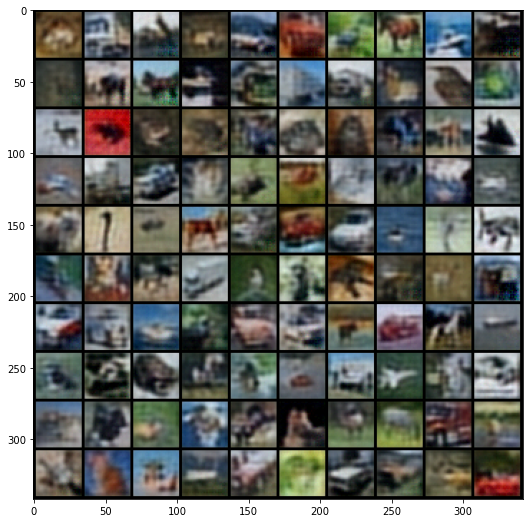

In [24]:
with torch.no_grad():
    x = acNet(im[0].to(device)).cpu()

    grid = make_grid(x, nrow=10, normalize=True)


plt.figure(figsize=(10, 9))
plt.imshow(np.transpose(grid, axes=(1, 2, 0)))

### Train the "AutoEncoder" model.

In [21]:
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(acNet.parameters(), lr=lr, betas=(beta1, 0.999))

In [23]:
losses = []
epochs = 10

start = time.time()

is_break = False

WINDOW_NAME = 'Frame'

cv2.namedWindow(WINDOW_NAME, flags=cv2.WINDOW_NORMAL)
cv2.resizeWindow(WINDOW_NAME, width=640, height=640)

for i in range(epochs):
    i += 1

    for batch, x in enumerate(train_loader):
        batch += 1

        x = x[0].to(device)

        optimizer.zero_grad()

        out = acNet(x)
        loss = criterion(out, x)

        if batch == 1 or batch % 500 == 0:
            losses.append(loss)
            print(f'Epoch: {i}, Batch: {batch} -> Loss: {loss}')

        loss.backward()
        optimizer.step()

        grid = make_grid(out.detach().cpu(), nrow=10, normalize=True).numpy()
        grid = cv2.cvtColor(np.transpose(grid, axes=(1, 2, 0)), code=cv2.COLOR_BGR2RGB)

        cv2.imshow(WINDOW_NAME, grid)

        if cv2.waitKey(1) & 0xFF == 27:
            is_break = True
            break

    if is_break:
        cv2.destroyWindow(WINDOW_NAME)
        break


cv2.destroyWindow(WINDOW_NAME)

duration = time.time() - start
print(f'Duration to execute: {duration / 60:.4f} minutes')

Epoch: 1, Batch: 1 -> Loss: 0.48741069436073303
Epoch: 1, Batch: 500 -> Loss: 0.015256726182997227
Epoch: 2, Batch: 1 -> Loss: 0.01594456471502781
Epoch: 2, Batch: 500 -> Loss: 0.0101951714605093
Epoch: 3, Batch: 1 -> Loss: 0.011186545714735985
Epoch: 3, Batch: 500 -> Loss: 0.007772700395435095
Epoch: 4, Batch: 1 -> Loss: 0.00909306388348341
Epoch: 4, Batch: 500 -> Loss: 0.006457992363721132
Epoch: 5, Batch: 1 -> Loss: 0.007901945151388645
Duration to execute: 1.5000 minutes


Text(0.5, 1.0, 'Loss x Epochs')

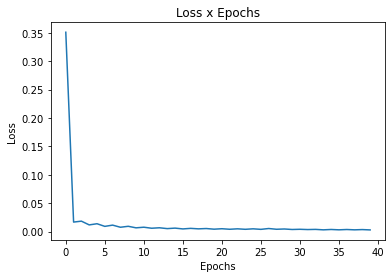

In [22]:
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss x Epochs')

### Play with Places365 Dataset.

In [9]:
places_train = dsets.ImageFolder(root=data_root_places, transform=transforms['places365'])
places_loader = DataLoader(places_train, batch_size=30, num_workers=workers, pin_memory=is_cuda)

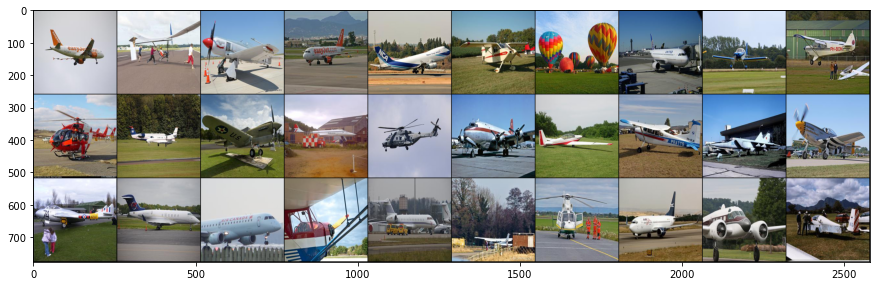

In [10]:
im = next(iter(places_loader))

grid = make_grid(im[0], nrow=10, normalize=True)

plt.figure(figsize=(15, 14))
plt.imshow(np.transpose(grid, axes=(1, 2, 0)))

In [11]:
class AutoEncoderPlace365(nn.Module):

    def __init__(self, in_channels=nz, out_channels=nc, pad=(0, 1, 0, 1)):
        super(AutoEncoderPlace365, self).__init__()

        # Convolutional Layers (ENCODE)
        self.encode = nn.Sequential(OrderedDict([
            ('conv1', nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=nf, kernel_size=4, stride=2),
                nn.ReplicationPad2d(padding=pad),
                nn.BatchNorm2d(nf),
                nn.ReLU()
            )),
            ('conv2', nn.Sequential(
                nn.Conv2d(in_channels=nf, out_channels=nf * 2, kernel_size=4, stride=2),
                nn.ReplicationPad2d(padding=pad),
                nn.BatchNorm2d(nf * 2),
                nn.ReLU()
            )),
            ('conv3', nn.Sequential(
                nn.Conv2d(in_channels=nf * 2, out_channels=nf * 4, kernel_size=4, stride=2, bias=False),
                nn.ReplicationPad2d(padding=pad),
                nn.BatchNorm2d(nf * 4),
                nn.ReLU()
            )),
            ('conv4', nn.Sequential(
                nn.Conv2d(in_channels=nf * 4, out_channels=nf * 8, kernel_size=4, stride=2, bias=False),
                nn.ReplicationPad2d(padding=pad),
                nn.BatchNorm2d(nf * 8),
                nn.ReLU()
            )),
            ('conv5', nn.Sequential(
                nn.Conv2d(in_channels=nf * 8, out_channels=nf * 8, kernel_size=4, stride=2, bias=False),
                nn.ReplicationPad2d(padding=pad),
                nn.BatchNorm2d(nf * 8),
                nn.ReLU()
            )),
            ('conv6', nn.Sequential(
                nn.Conv2d(in_channels=nf * 8, out_channels=nf * 8, kernel_size=4, stride=2, bias=False),
                nn.ReplicationPad2d(padding=pad),
                nn.BatchNorm2d(nf * 8),
                nn.ReLU()
            )),
        ]))

        self.decode = nn.Sequential(OrderedDict([
            ('conv1', nn.Sequential(
                nn.ConvTranspose2d(in_channels=nf * 8, out_channels=nf * 8, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(nf * 8),
                nn.ReLU(),
            )),
            ('conv2', nn.Sequential(
                nn.ConvTranspose2d(in_channels=nf * 16, out_channels=nf * 8, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(nf * 8),
                nn.ReLU()
            )),
            ('conv3', nn.Sequential(
                nn.ConvTranspose2d(in_channels=nf * 16, out_channels=nf * 4, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(nf * 4),
                nn.ReLU()
            )),
            ('conv4', nn.Sequential(
                nn.ConvTranspose2d(in_channels=nf * 8, out_channels=nf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(nf * 2),
                nn.ReLU()
            )),
            ('conv5', nn.Sequential(
                nn.ConvTranspose2d(in_channels=nf * 4, out_channels=nf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(nf),
                nn.ReLU()
            )),
            ('conv6', nn.Sequential(
                nn.ConvTranspose2d(in_channels=nf * 2, out_channels=nc, kernel_size=4, stride=2, padding=1, bias=False),
                nn.ReLU()
            ))
        ]))

        self.encode_children = dict(self.encode.named_children())
        self.decode_children = dict(self.decode.named_children())

    def forward(self, x):
        conv1 = self.encode_children['conv1'](x)
        conv2 = self.encode_children['conv2'](conv1)
        conv3 = self.encode_children['conv3'](conv2)
        conv4 = self.encode_children['conv4'](conv3)
        conv5 = self.encode_children['conv5'](conv4)
        conv6 = self.encode_children['conv6'](conv5)

        conv7 = torch.cat([self.decode_children['conv1'](conv6), conv5], dim=1)
        conv8 = torch.cat([self.decode_children['conv2'](conv7), conv4], dim=1)
        conv9 = torch.cat([self.decode_children['conv3'](conv8), conv3], dim=1)
        conv10 = torch.cat([self.decode_children['conv4'](conv9), conv2], dim=1)
        conv11 = torch.cat([self.decode_children['conv5'](conv10), conv1], dim=1)
        conv12 = self.decode_children['conv6'](conv11)
        return conv12


acNet365 = AutoEncoderPlace365().to(device)
acNet365

AutoEncoderPlace365(
  (encode): Sequential(
    (conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2))
      (1): ReplicationPad2d((0, 1, 0, 1))
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
    )
    (conv2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
      (1): ReplicationPad2d((0, 1, 0, 1))
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
    )
    (conv3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), bias=False)
      (1): ReplicationPad2d((0, 1, 0, 1))
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
    )
    (conv4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), bias=False)
      (1): ReplicationPad2d((0, 1, 0, 1))
      (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, tr

torch.Size([10, 3, 256, 256])


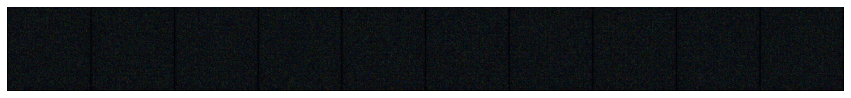

In [12]:
with torch.no_grad():
    x = torch.rand(10, 3, 256, 256, device=device)
    x = acNet365(x).cpu()

    print(x.shape)

    grid = make_grid(x, nrow=10, normalize=True)

    plt.figure(figsize=(15, 14))
    plt.imshow(np.transpose(grid, axes=(1, 2, 0)))
    plt.axis('off')

### Train Places365 Model

In [13]:
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(acNet365.parameters(), lr=lr, betas=(beta1, 0.999))

In [14]:
torch.cuda.empty_cache()

batch_limit = 1000

losses = []
epochs = 10

WINDOW_NAME = "Places365 Frames"

cv2.namedWindow(WINDOW_NAME, flags=cv2.WINDOW_NORMAL)
cv2.resizeWindow(WINDOW_NAME, width=1280, height=384)

is_destroy = False

start = time.time()

for i in range(epochs):
    i += 1

    for batch, x in enumerate(places_loader):
        batch += 1

        optimizer.zero_grad()

        x = x[0].to(device)

        out = acNet365(x)
        loss = criterion(out, x)

        losses.append(loss)

        if batch == 1 or batch % 200 == 0:
            print(f'Epoch: {i}, Batch: {batch} -> Loss: {loss}')

        grid = make_grid(out.detach().cpu(), nrow=10, normalize=True).numpy()
        grid = cv2.cvtColor(np.transpose(grid, axes=(1, 2, 0)), code=cv2.COLOR_BGR2RGB)

        cv2.imshow(WINDOW_NAME, grid)

        if cv2.waitKey(1) & 0xFF == 27:
            is_destroy = True
            break

        loss.backward()
        optimizer.step()

        if batch_limit == batch:
            break

    if is_destroy:
        cv2.destroyWindow(WINDOW_NAME)
        break

duration = time.time() - start
print(f'Duration to execute: {duration / 60:.4f} minutes')

Epoch: 1, Batch: 1 -> Loss: 0.46239545941352844
Epoch: 1, Batch: 200 -> Loss: 0.025614971294999123
Epoch: 1, Batch: 400 -> Loss: 0.016295170411467552
Epoch: 1, Batch: 600 -> Loss: 0.00526422681286931
Epoch: 1, Batch: 800 -> Loss: 0.005037188064306974
Epoch: 1, Batch: 1000 -> Loss: 0.006652189884334803
Epoch: 2, Batch: 1 -> Loss: 0.0058957659639418125
Epoch: 2, Batch: 200 -> Loss: 0.0037589557468891144
Epoch: 2, Batch: 400 -> Loss: 0.0043955519795417786
Epoch: 2, Batch: 600 -> Loss: 0.0021725513506680727
Epoch: 2, Batch: 800 -> Loss: 0.002337633864954114
Epoch: 2, Batch: 1000 -> Loss: 0.0037964582443237305
Epoch: 3, Batch: 1 -> Loss: 0.0036691913846880198
Epoch: 3, Batch: 200 -> Loss: 0.002367516979575157
Epoch: 3, Batch: 400 -> Loss: 0.002611141186207533
Epoch: 3, Batch: 600 -> Loss: 0.0016399851301684976
Epoch: 3, Batch: 800 -> Loss: 0.0016489651752635837
Epoch: 3, Batch: 1000 -> Loss: 0.0029490424785763025
Epoch: 4, Batch: 1 -> Loss: 0.0029742433689534664
Epoch: 4, Batch: 200 -> Loss

Text(0.5, 1.0, 'Epochs x Loss')

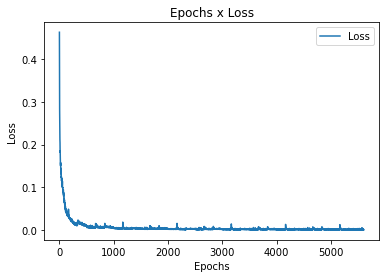

In [15]:
plt.plot(losses, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Epochs x Loss')

In [13]:
cv2.destroyAllWindows()